---
### Includes

In [1]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('LunarLander-v2')

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

---
### Helper functions

In [101]:
def plot_durations(episode_durations, state_visits):
    fig, axs = plt.subplots(2, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    durations = torch.tensor(durations, dtype=torch.float)
    visits_t = [(x[0], torch.tensor(x[1], dtype=torch.float)) for x in state_visits.items()]
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('State Visits')
    
    axs[0].plot(durations_t, durations.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axs[0].plot(durations_t, means.numpy())
    
    if len(durations_t) >= 10:
        for t in visits_t:
            means = t[1].unfold(0, 10, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(9), means))
            axs[1].plot(means.numpy(), label=f"State {t[0]}")
            axs[1].legend()
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

---
### Code

In [3]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
def plot_norms(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    x, ys = np.array(list(episode_durations.keys())), np.array(list(episode_durations.values()))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm')
    plt.ylabel('Average Reward')
    
    mu = np.mean(ys, axis=1)
    plt.plot(x / 10, mu)
    stds = np.std(ys, axis = 1)
    plt.fill_between(x / 10, mu + stds , mu - stds, alpha=0.2)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [117]:
BATCH_SIZE = 64
GAMMA = 0.99

def one_hot(n, v):
    a = np.zeros(n)
    a[v] = 1.0
    return np.expand_dims(a, axis=0)

def rev_one_hot(a):
    return np.where(a[0] > 0)[0][0]

class DQN(nn.Module):
    def __init__(self, inputs, outputs, mem_len = 100000):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)
        
        self.memory = ReplayMemory(mem_len)
        self.optimizer = None
        self.target = None # to keep parameters frozen while propogating losses
        
        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS = 1.0
        self.EPS_END = 0.1
        self.EPS_DECAY = 0.99995
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state):       
        if self.EPS > self.EPS_END:
            self.EPS *= self.EPS_DECAY
            
        self.steps_done += 1

        # With probability eps select a random action
        if random.random() < self.EPS:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)

        non_final_mask = 1 - done_mask
        
        current_Q_values = self(state_batch).gather(1, action_batch)
        
        # Double DQN aproach
        #next_Q_values = torch.zeros(BATCH_SIZE, device = device)
        #next_state_actions = self(next_state_batch).max(1, keepdim=True)[1]
        #next_Q_values[non_final_mask] = self.target(next_state_batch).gather(1, next_state_actions).squeeze(1).detach()
        
        # simple DQN approach
        next_max_q = self.target(next_state_batch).max(1)[0].detach()
        next_Q_values = not_done_mask * next_max_q
        
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        
        # Compute Bellman error (using Huber loss)
        loss = F.mse_loss(current_Q_values, target_Q_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [118]:
def train_model():
    # Get number of actions and observations from gym action space
    n_actions = env.action_space.n
    n_observations = env.observation_space.shape[0]

    # Initialize action-value function Q with random weights
    dqnAgent = DQN(n_observations, n_actions).to(device)
    dqnAgent.target = DQN(n_observations, n_actions).to(device)

    # Optimizer
    dqnAgent.optimizer = optim.Adam(dqnAgent.parameters(), lr = 0.001)

    num_episodes = 1000 # M
    episode_durations = []
    state_visits = {0: [], 1: [], 2: [], 3: []}

    for i_episode in range(num_episodes):
        observation = env.reset()
        # unsqueeze adds batch dimension
        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        overall_reward = 0
        ep_state_visits = {0: 0, 1: 0, 2: 0, 3: 0}
        done = False
        while not done:
            # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
            action = dqnAgent.act(state)
            observation, reward, done, _ = env.step(action.item())
            extrinsic_reward = torch.tensor([reward], device=device, dtype=torch.float)

            overall_reward += reward

            ep_state_visits[action.item()] += 1

            # preprocess φ_{t+1} = φ(s_{t+1})
            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            # Store transition (φt, at, rt, φt+1) in D
            dqnAgent.memory.store(state, action, next_state, extrinsic_reward, done)

            state = next_state

            dqnAgent.experience_replay()

        # very needed! see https://stackoverflow.com/a/58730298
        if i_episode % 10 == 0:
            dqnAgent.target.load_state_dict(dqnAgent.state_dict(), strict = False)

        episode_durations.append((i_episode, overall_reward))
        for i in ep_state_visits.keys():
            state_visits[i].append(ep_state_visits[i])
        plot_durations(episode_durations, state_visits)

    return dqnAgent

In [109]:
def eval_model(dqnAgent, episode_durations):
    dqnAgent.eval()

    num_episodes = 100

    for l2norm in range(20):

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()
            # unsqueeze adds batch dimension
            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            done = False
            while not done:
                state = state * (np.ones(len(observation)) + (l2norm/10)*(np.random.random(len(observation)) - 0.5))
                state = state.float()
                action = dqnAgent.act(state)
                observation, reward, done, _ = env.step(action.item())
                overall_reward += reward

                state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        episode_durations[l2norm].append(overall_reward / num_episodes)

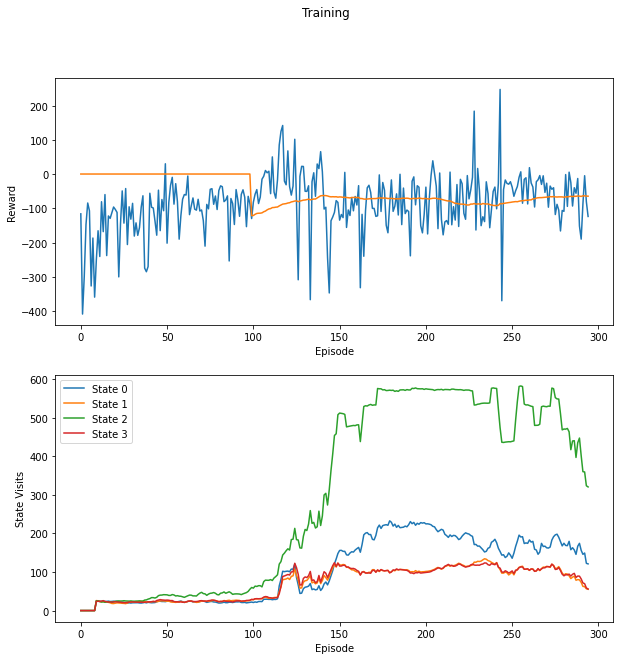

KeyboardInterrupt: 

In [119]:
agent = train_model()

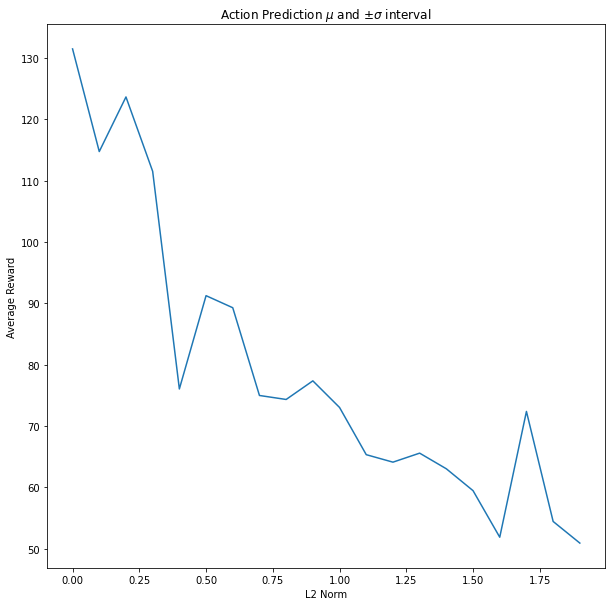

In [38]:
episodes = {}
for l2norm in range(20):
    episodes[l2norm] = []

eval_model(agent, episodes)
plot_norms(episodes)

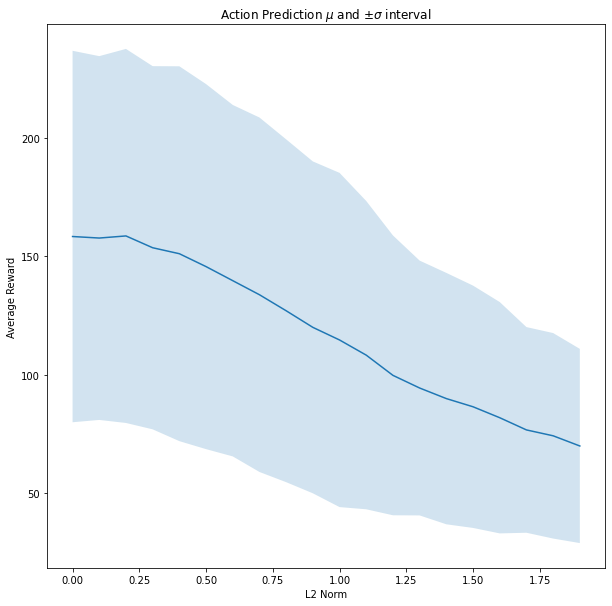

In [47]:
episodes = {}
for l2norm in range(20):
    episodes[l2norm] = []

# train 20 models for 200 steps, then eval them
for i in range(20):
    agent = train_model()
    eval_model(agent, episodes)
    plot_norms(episodes)

plot_norms(episodes)

In [48]:
import json
json = json.dumps(episodes)
f = open("dqn_episodes.json","w")
f.write(json)
f.close()

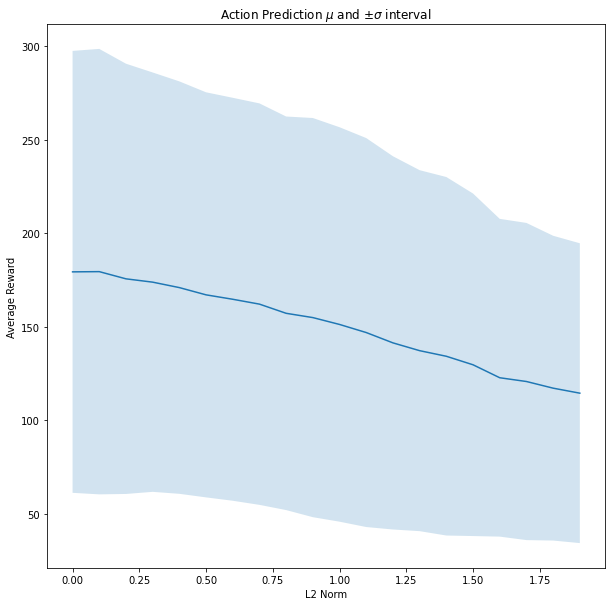

In [44]:
plot_norms(episodes)